## General Case (Empirical)

$$
LVR =  \sum_{i=1}^{n} a_i \cdot (p_i - q_i)
$$

$a_i$ : Amount of Token Sold

$p_i$ : Market Price

$q_i$ : AMM Price

# Aggregate AMM trades over a block

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the swaps dataframe from your data source
df = pd.read_csv('USDCETH_swap.csv', index_col=0)

df['AMM_price'] = abs(df['amount_token0'] / df['amount_token1'])

df['abs_amount_token0'] = abs(df['amount_token0'])

df['weighted_price'] = df['AMM_price'] * df['abs_amount_token0']

# Group the dataframe by 'block_number' and aggregate the columns
grouped_df = df.groupby('block_number').agg({
    'amount_token0': 'sum',
    'abs_amount_token0': 'sum',
    'amount_token1': 'sum',
    'weighted_price': 'sum',
    'Price': 'mean',
}).reset_index()

# Calculate the weighted mean by dividing the sum of weighted prices by the sum of amount_token0
grouped_df['AMM_weighted_price'] = grouped_df['weighted_price'] / grouped_df['abs_amount_token0']

# Drop the temporary 'weighted_price' column
grouped_df = grouped_df.drop('weighted_price', axis=1)
grouped_df = grouped_df.drop('abs_amount_token0', axis=1)



### Obtain Block Timestamps from Google Big Query and add to dataframe

In [4]:
# get data from timestamps_blocktime
timestamps_blocktime = pd.read_csv('timestamps_blocktime.csv')
# convert datetime to timestamp
timestamps_blocktime['timestamp'] = pd.to_datetime(timestamps_blocktime['timestamp']).astype(int) / 10**9
timestamps_blocktime['timestamp'] = timestamps_blocktime['timestamp'].astype(int)

In [5]:
# Get data from 17285000 to 17631700 as that is when Range launched
block_data = grouped_df[grouped_df['block_number'] >= 17285000]
# create a column called timestamp. block 17285000 is 1684395467. Every subsequent block is 12 seconds
block_data['timestamp'] = block_data['block_number'].apply(lambda x: 1684395467 + (x - 17285000) * 12)

# create a column called timestamp2 which is the timestamp from timestamps_blocktime dataframe
# check that block_number in block_data is in timestamps_blocktime and then add the timestamp

def get_timestamp(block_number):
    if block_number in timestamps_blocktime['block_number'].values:
        return timestamps_blocktime[timestamps_blocktime['block_number'] == block_number]['timestamp'].values[0]
    else:
        return None
    
block_data['timestamp2'] = block_data['block_number'].apply(get_timestamp)


/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_8998/471087559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_data['timestamp'] = block_data['block_number'].apply(lambda x: 1684395467 + (x - 17285000) * 12)
/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_8998/471087559.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_data['timestamp2'] = block_data['block_number'].apply(get_timestamp)


In [6]:
# add a column called AMM_price by dividing amount_token0 by amount_token1
block_data['AMM_price'] =abs(block_data['amount_token0'] / block_data['amount_token1'])
block_data_sample = block_data
block_data_sample

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_8998/3365752267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_data['AMM_price'] =abs(block_data['amount_token0'] / block_data['amount_token1'])


,block_number,amount_token0,amount_token1,Price,AMM_weighted_price,timestamp,timestamp2,AMM_price
563904,17285004,10000.000000,-5.485844,1822.067754,1822.873505,1684395515,1684395515,1822.873505
563905,17285005,-185020.955304,101.600889,1822.067754,1821.056461,1684395527,1684395527,1821.056461
563906,17285007,289204.492739,-158.626310,1822.614429,1823.181113,1684395551,1684395551,1823.181113
563907,17285009,-122227.927301,67.229540,1822.158876,1821.958427,1684395575,1684395575,1818.068783
563908,17285010,146873.624753,-80.549997,1822.796691,1823.384605,1684395587,1684395587,1823.384605
...,...,...,...,...,...,...,...,...
707755,17626307,-3997.398083,2.064475,1937.248990,1936.278055,1688491151,1688543399,1936.278055
707756,17626308,1457.979055,-0.752228,1937.248990,1938.213459,1688491163,1688543423,1938.213459
707757,17626312,-26016.496670,13.436515,1937.248990,1936.253244,1688491211,1688543471,1936.253244
707758,17626333,-2548.353650,1.316144,1937.248990,1936.227091,1688491463,1688543723,1936.227091


### Get Binance Klines Data for the trading pair

In [8]:
# get start and end timestamps in swaps

start_timestamp = int(block_data_sample['timestamp2'].min() * 1000)
end_timestamp = int(block_data_sample['timestamp2'].max() * 1000)
print(start_timestamp, end_timestamp)

# convert the timestamps into datetime, singapore time
start_datetime = pd.to_datetime(start_timestamp, unit='ms') + pd.Timedelta(hours=8)
end_datetime = pd.to_datetime(end_timestamp, unit='ms') + pd.Timedelta(hours=8)

print(start_datetime, "to", end_datetime)

# get the difference between the two timestamps in hours
diff = (end_timestamp - start_timestamp) / 1000 / 60 / 60
print(diff,"hours")

1684395515000 1688543783000
2023-05-18 15:38:35 to 2023-07-05 15:56:23
1152.2966666666666 hours


In [1452]:
import requests
import random

# List of User-Agent strings to simulate different devices
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
]

# Helper function to get binance klines over a period longer than 1000 seconds
def get_binance_klines(symbol, startTime, endTime):
    url = "https://api.binance.com/api/v3/uiKlines"
    params = {
        "symbol": symbol,
        "interval": "1s",
        "startTime": startTime,
        "endTime": 1688535695000,
        "limit": "1000"
    }

    data = []

    while True:
        # Randomly select a User-Agent from the list
        user_agent = random.choice(user_agents)
        
        headers = {
            "User-Agent": user_agent
        }
        
        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            batch_data = response.json()
            data.extend(batch_data)

            if len(batch_data) < 2:
                break

            # Update the startTime parameter for the next batch
            params["startTime"] = str(int(batch_data[-1][0]) + 1)
        else:
            print("Request failed with status code:", response.status_code)
            break

    return data


In [1453]:
response = get_binance_klines("ETHUSDC", start_timestamp, end_timestamp)
klines_data = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000
klines_data = klines_data[['open_time', 'close_time', 'close']]
klines_data['open_time'] = klines_data['open_time'] / 1000
klines_data['close_time'] = klines_data['close_time'] / 1000

# convert open_time and close_time to int
klines_data['open_time'] = klines_data['open_time'].astype(int)
klines_data['close_time'] = klines_data['close_time'].astype(int)

klines_data

,open_time,close_time,close
0,1684395515,1684395515,1822.54000000
1,1684395516,1684395516,1822.54000000
2,1684395517,1684395517,1822.54000000
3,1684395518,1684395518,1822.54000000
4,1684395519,1684395519,1822.54000000
...,...,...,...
4140176,1688535691,1688535691,1935.43000000
4140177,1688535692,1688535692,1935.43000000
4140178,1688535693,1688535693,1935.43000000
4140179,1688535694,1688535694,1935.43000000


In [1585]:
# save the klines data to csv indicating time stamp rnage
klines_data.to_csv(f'ETHUSDC_klines_{start_timestamp}_{end_timestamp}.csv')

In [9]:
# open saved klines data from csv
klines_data = pd.read_csv(f'ETHUSDC_klines_{start_timestamp}_{end_timestamp}.csv')

In [12]:
# merge swaps and klines_data on timestamp and close_time
merged = pd.merge(block_data_sample, klines_data, left_on='timestamp2', right_on='close_time')

# drop open_time and close_time and liquidity and tick and transaction_index and log_index
merged = merged.drop(columns=['open_time', 'close_time'])

merged['close'] = merged['close'].astype(float)

# Remove items where amount_token1 or amount_token0 is 0
merged = merged[merged['amount_token1'] != 0]
merged = merged[merged['amount_token0'] != 0]

# Create a column called action which is labelled either buy or sell depending on whether amount_token1 is positive or negative
merged['pool_action'] = np.where(merged['amount_token1'] > 0, 'buy', 'sell')

# Trader action is the opposite of pool action
merged['trader_action'] = np.where(merged['pool_action'] == 'buy', 'sell', 'buy')

# calculate LVR amount_token1*-1 * (close - AMM_price)
merged['LVR'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_price'])

# calculate LVR 2 amount_token1*-1 * (close - Price)
merged['LVR2'] = merged['amount_token1'] * -1 * (merged['close'] - merged['Price'])

# calculate LVR 3 amount_token1*-1 * (close - AMM_weighted_price)
merged['LVR3'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_weighted_price'])

# create a column for cumulative LVR sum
merged['cum_LVR'] = merged['LVR'].cumsum()

# create a column for cumulative LVR2 sum
merged['cum_LVR2'] = merged['LVR2'].cumsum()

# create a column for cumulative LVR3 sum
merged['cum_LVR3'] = merged['LVR3'].cumsum()


# order the columns in this order timestamp, block_numner, transaction_index, price, amm_price, close, pool_action, trader_action, LVR, cum_LVR
merged = merged[['timestamp', 'block_number', 'Price', 'AMM_price','AMM_weighted_price' ,'close', 'amount_token0', 'amount_token1','pool_action', 'trader_action', 'LVR', 'LVR2','LVR3','cum_LVR','cum_LVR2', 'cum_LVR3']]

# rename close to Close_price
merged = merged.rename(columns={'close': 'Close_price'})


# remove items where amount_token0 is less than 0.001
# merged = merged[abs(merged['amount_token1']) > 0.001]

## Using Price from Net Trade

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


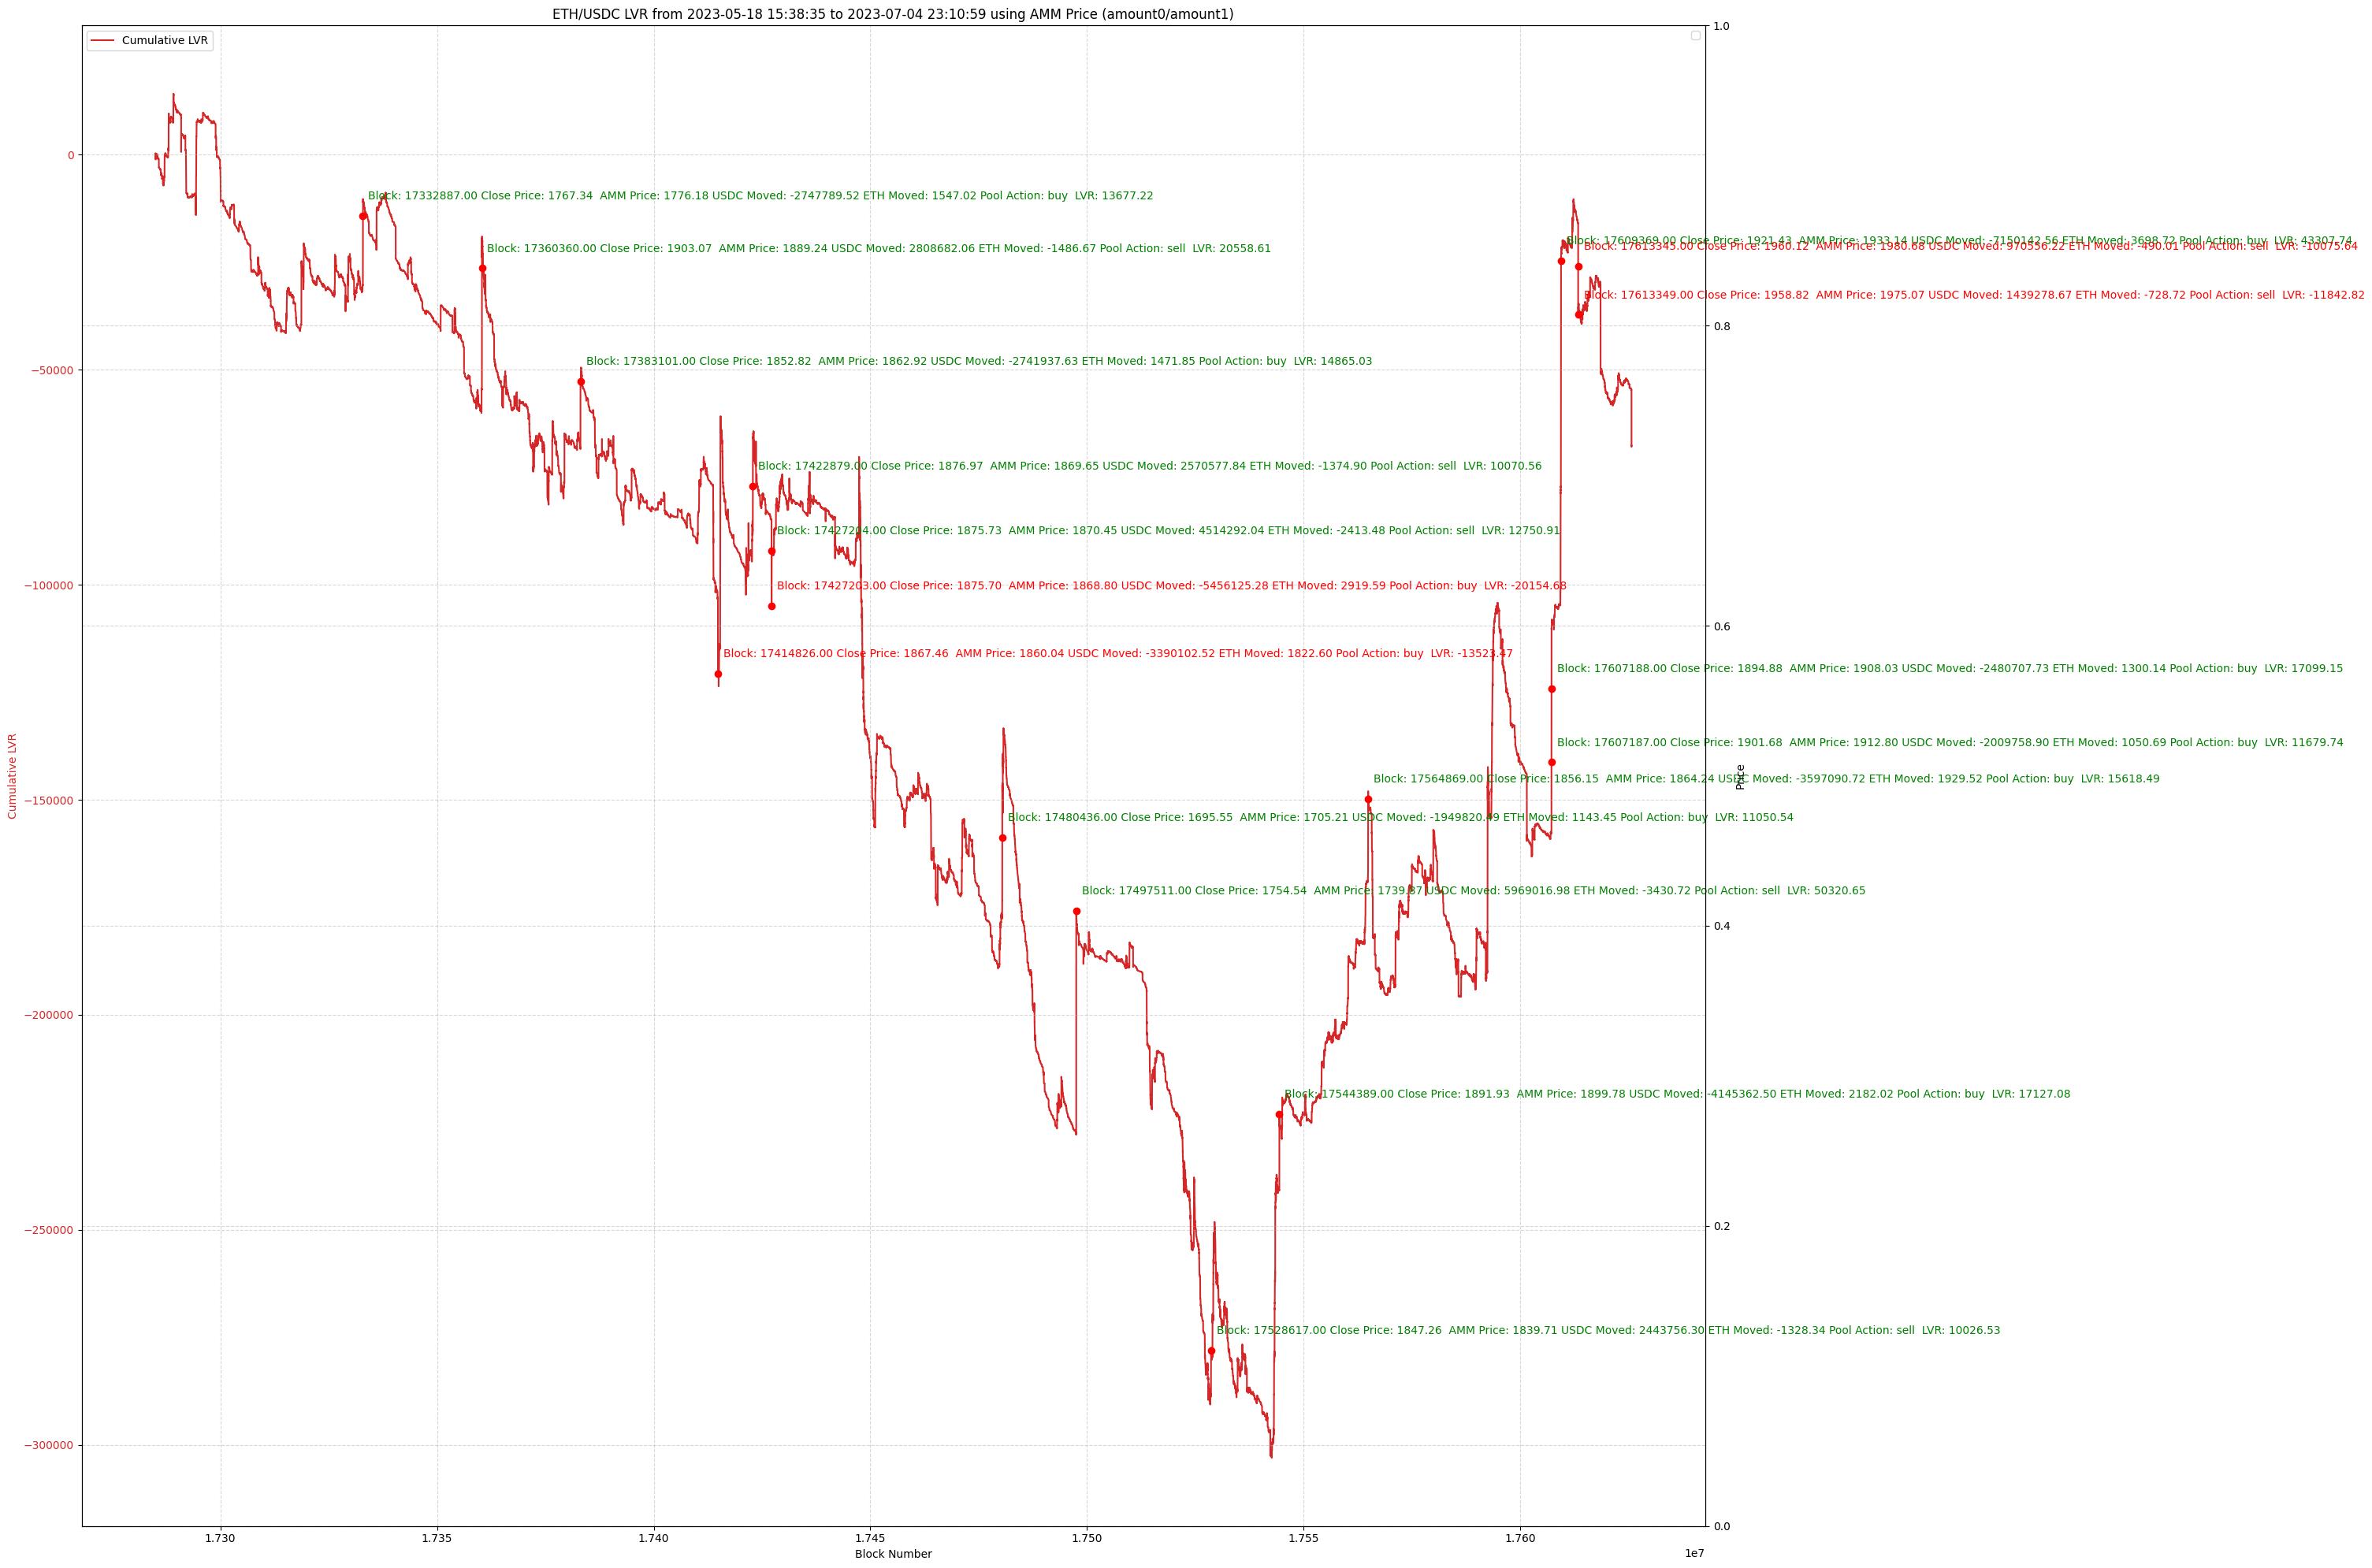

In [13]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR'], color=color1, label='Cumulative LVR', zorder=1)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(merged['block_number'], merged['AMM_price'], color=color2, label='AMM Price', zorder=1)
# ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=1)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using AMM Price (amount0/amount1)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR'].iloc[i] - merged['cum_LVR'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [1665]:
merged['cum_LVR'].iloc[-1]

-67632.95704971599

## Using Price from Tick

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


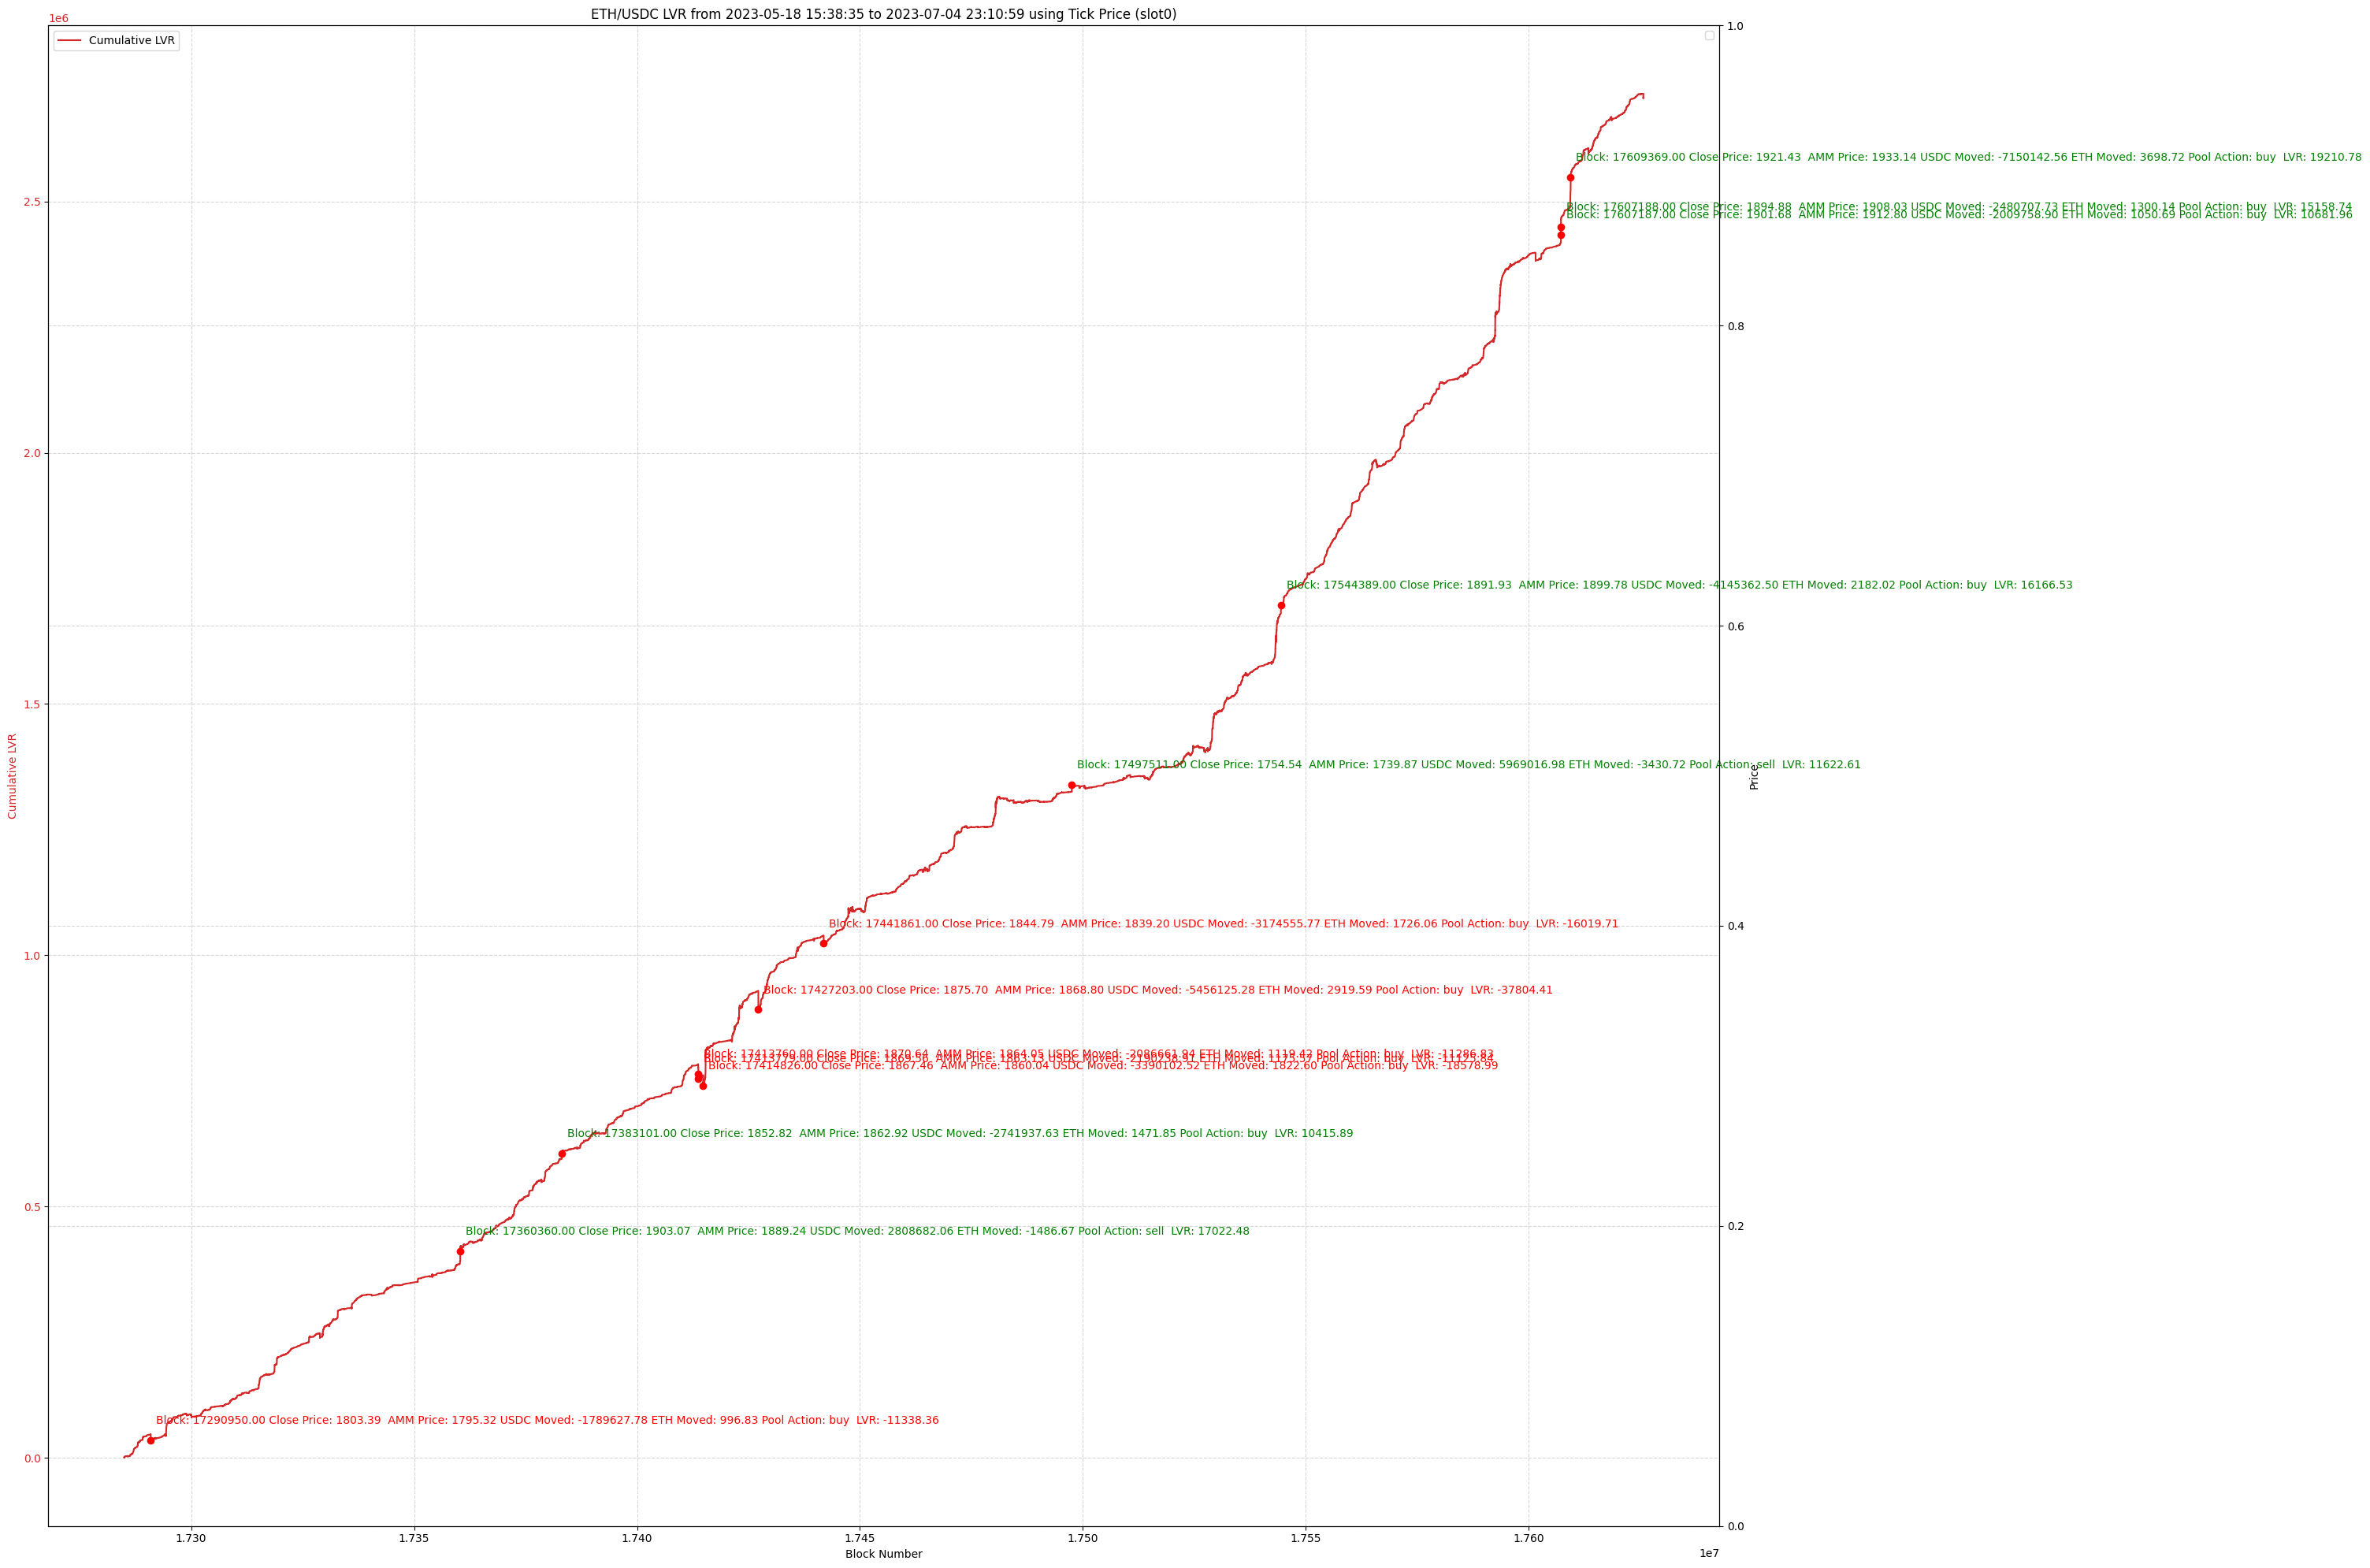

In [14]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR2'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(merged['block_number'], merged['Price'], color=color2, label='Tick Price', zorder=3)
# ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR2'].iloc[i] - merged['cum_LVR2'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR2'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [15]:
merged['cum_LVR2'].iloc[-1]

2705349.215794312

## Using Weighted Average Price across the Block

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


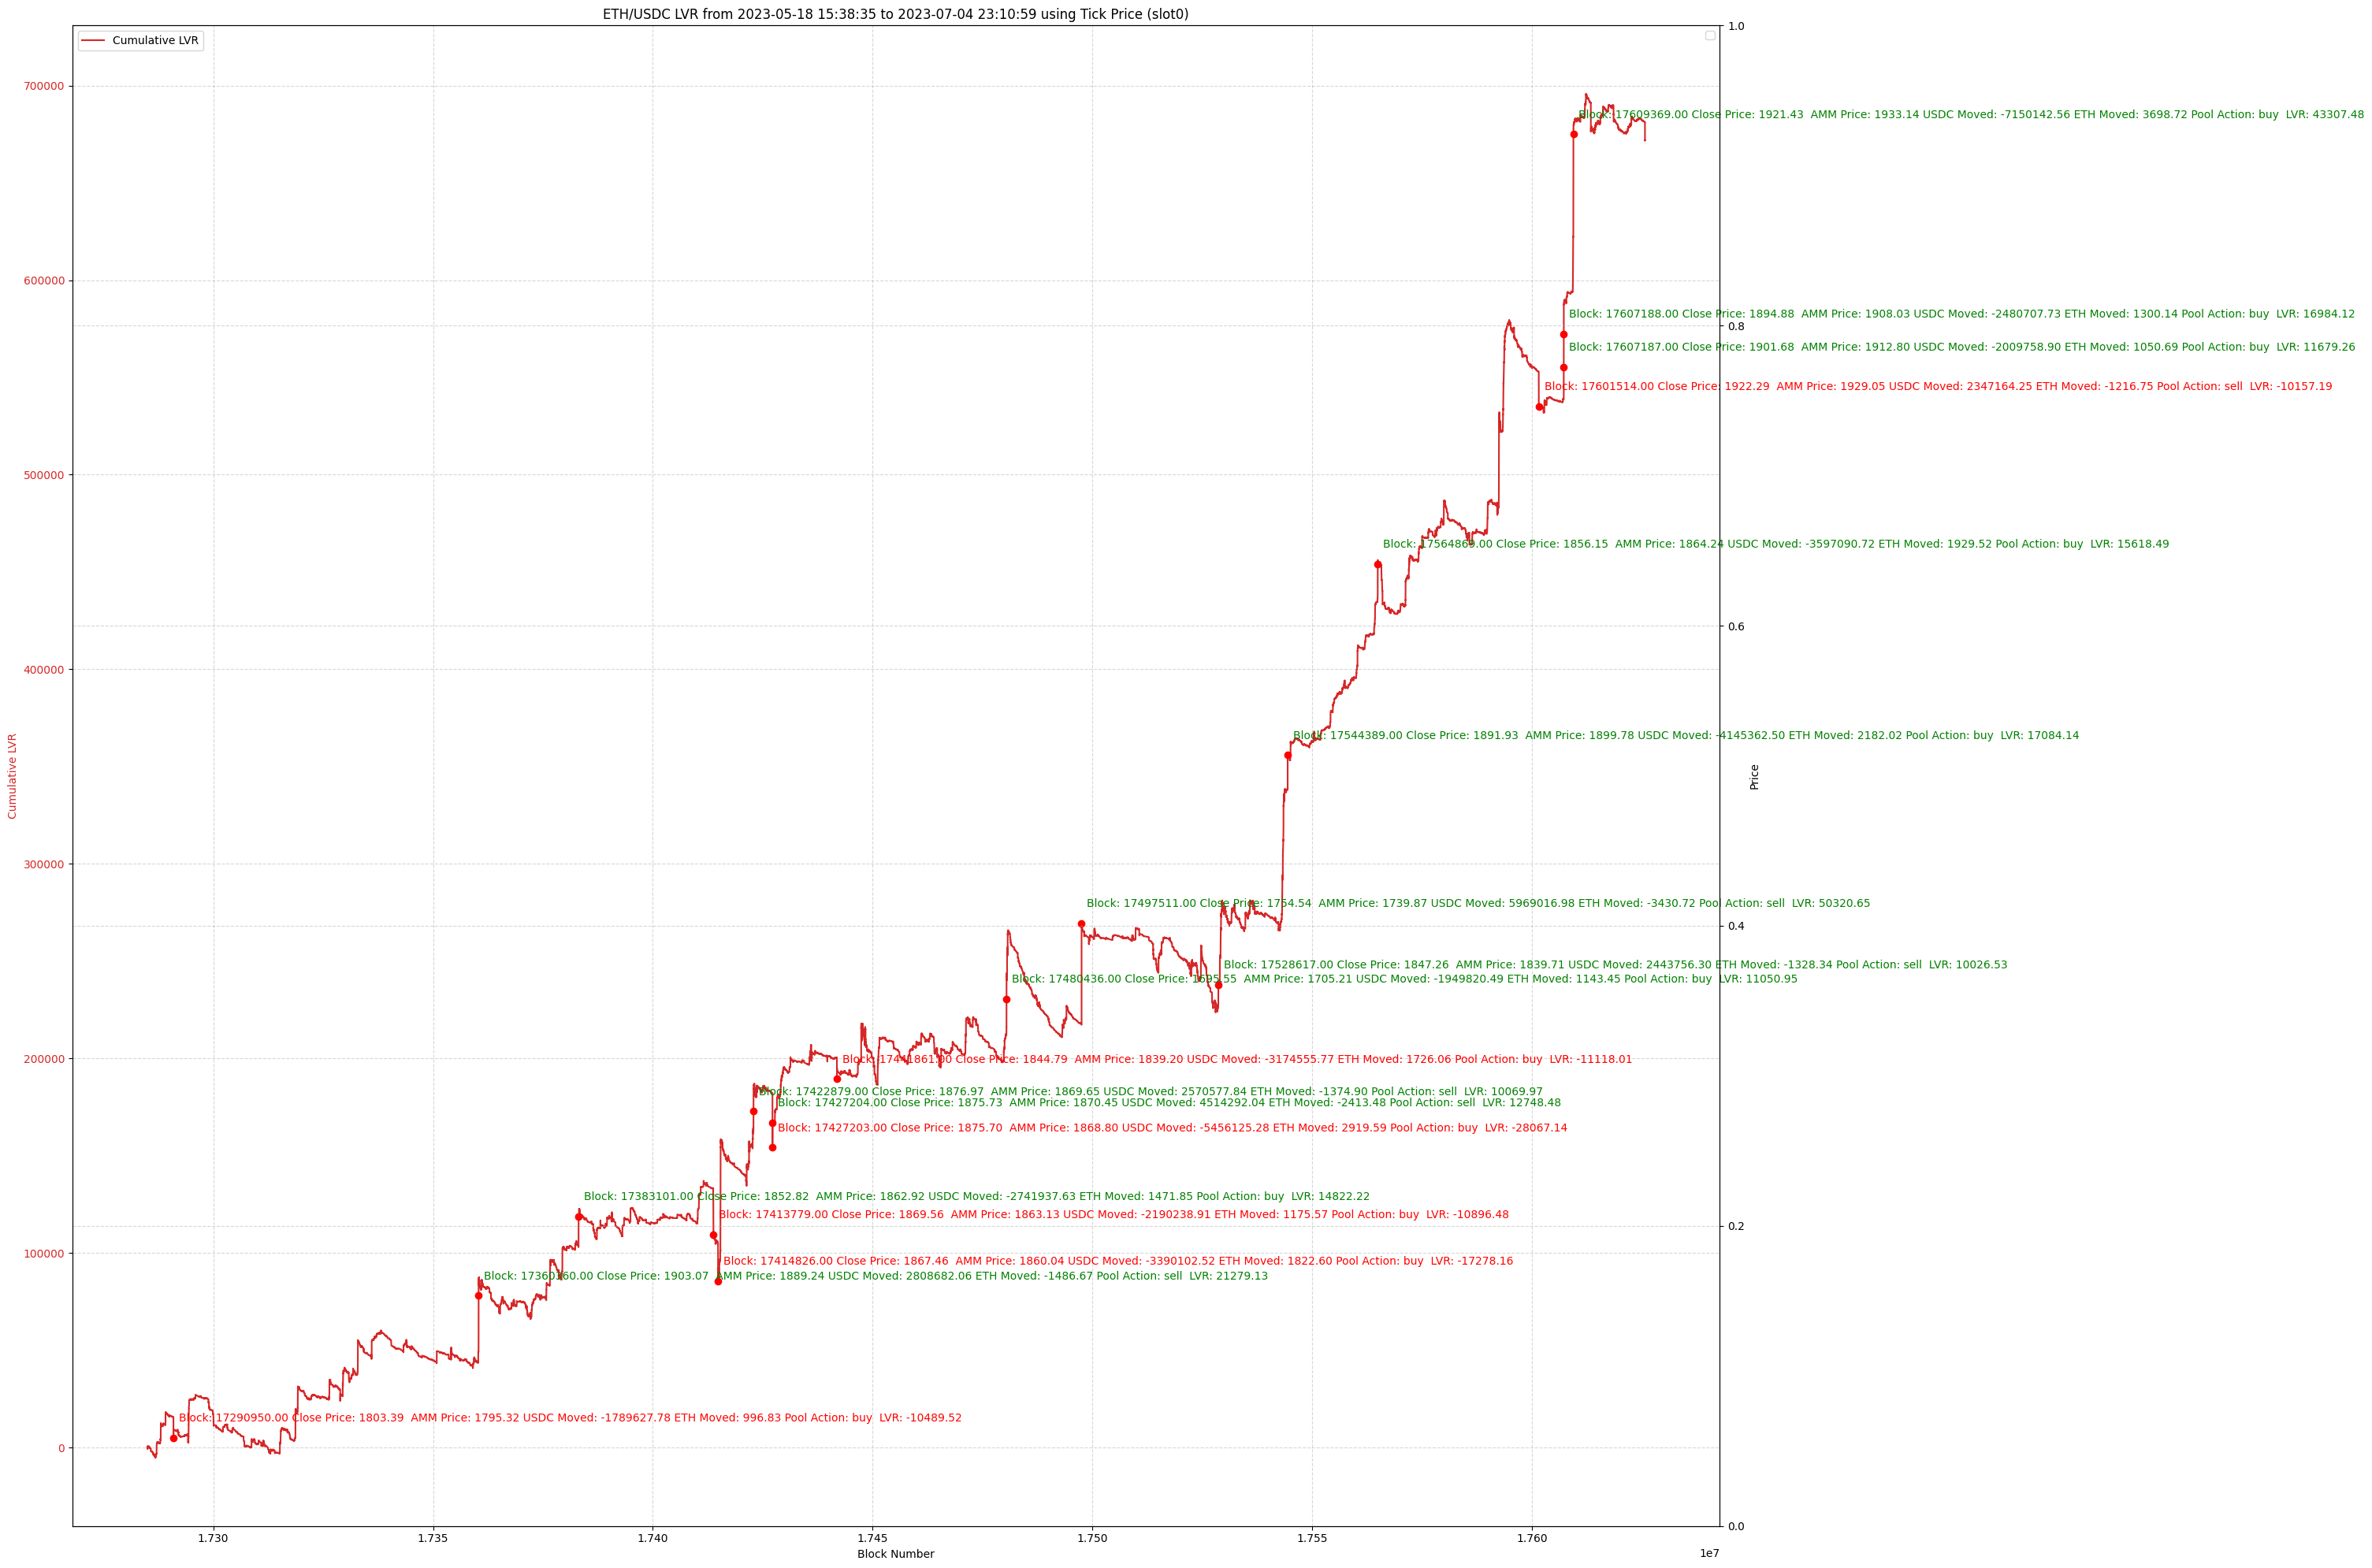

In [16]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR3'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(merged['block_number'], merged['Price'], color=color2, label='Tick Price', zorder=3)
# ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR3'].iloc[i] - merged['cum_LVR3'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR3'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [17]:
merged['cum_LVR3'].iloc[-1]

671925.1669487898

In [1682]:
# compile the results in a table
results = pd.DataFrame({
                        'Time Period': [f'{first_timestamp} to {last_timestamp}'],
                        'Total LVR1': [merged['cum_LVR'].iloc[-1]],
                        'Total LVR2': [merged['cum_LVR2'].iloc[-1]],
                        'Total LVR3': [merged['cum_LVR3'].iloc[-1]],})

results


,Time Period,Total LVR1,Total LVR2,Total LVR3
0,2023-05-18 15:38:35 to 2023-07-04 23:10:59,-67632.95705,2.705349e+06,671925.166949


In [1730]:
# create new column called slippage that is the percentage difference between the AMM price and the tick price
merged['slippage'] = abs((merged['AMM_weighted_price'] - merged['Price']) / merged['Price'] * 100)


In [1731]:
test = merged
# create column for absolute value of LVR3
test['abs_LVR3'] = abs(test['LVR3'])
# get 99th percentile value of abs_LVR3
threshold = test['abs_LVR3'].quantile(0.9999)
print(threshold)

10370.148560855143


## Visualise Difference in AMM Price and Slot0 Price

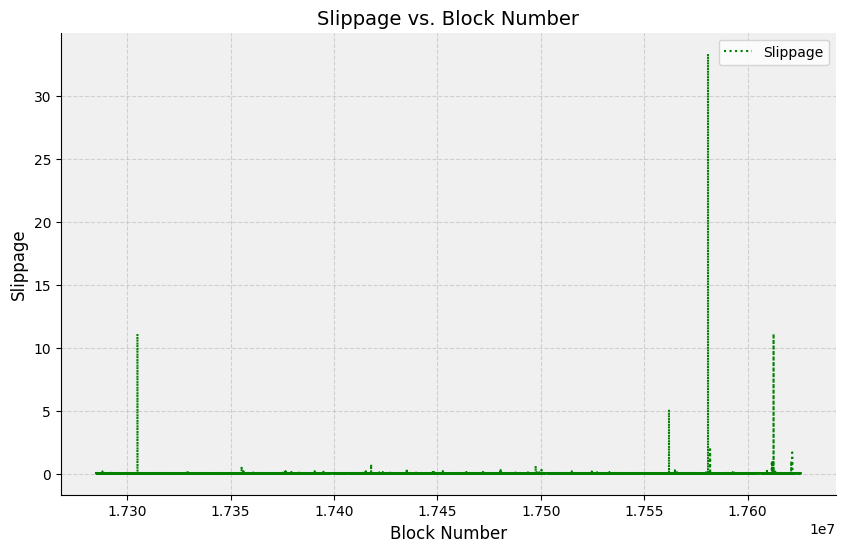

In [1673]:
import matplotlib.pyplot as plt

# Assuming you have the data stored in a pandas DataFrame called "merged"
# You can extract the required columns
block_number = test['block_number']
slippage = test['slippage']

# Set the figure size
plt.figure(figsize=(10, 6))

# Creating a plot for slippage
plt.plot(block_number, slippage, label='Slippage', linestyle=':', color='green')

# Adding labels and title to the plot with customized font size
plt.xlabel('Block Number', fontsize=12)
plt.ylabel('Slippage', fontsize=12)
plt.title('Slippage vs. Block Number', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting the tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Adding a background color to the plot area
plt.gca().set_facecolor('#f0f0f0')

# Adding a border around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


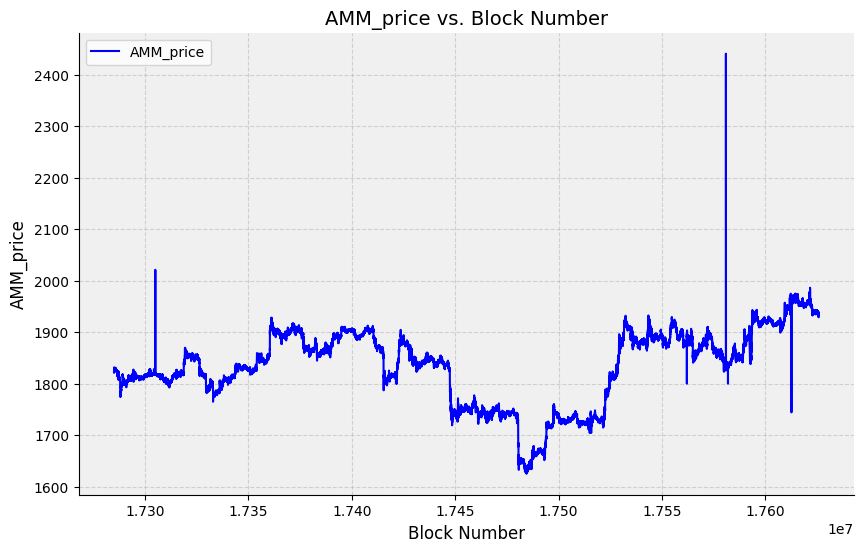

In [1675]:
import matplotlib.pyplot as plt

# Assuming you have the data stored in a pandas DataFrame called "merged"
# You can extract the required columns
block_number = test['block_number']
amm_price = test['AMM_weighted_price']

# Set the figure size
plt.figure(figsize=(10, 6))

# Creating a plot for AMM_price
plt.plot(block_number, amm_price, label='AMM_price', color='blue')

# Adding labels and title to the plot with customized font size
plt.xlabel('Block Number', fontsize=12)
plt.ylabel('AMM_price', fontsize=12)
plt.title('AMM_price vs. Block Number', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting the tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Adding a background color to the plot area
plt.gca().set_facecolor('#f0f0f0')

# Adding a border around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


In [1714]:
test = merged

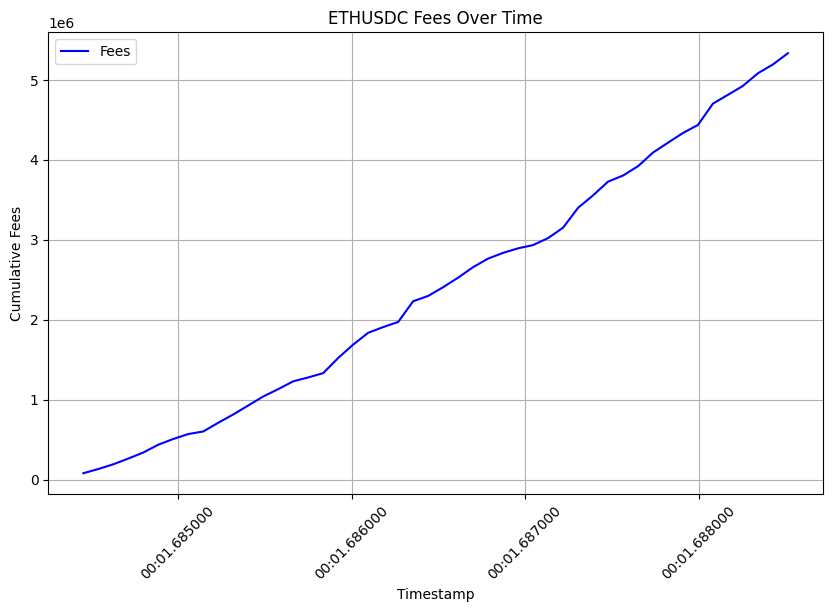

In [1718]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
fees = pd.read_csv('ETHUSDC_fees.csv')

# create a column for cumulative fees
fees['cum_fees'] = fees['Fees'].cumsum()

# Convert 'Timestamp' column to datetime type
fees['Timestamp'] = pd.to_datetime(fees['Timestamp'])

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data
plt.plot(fees['Timestamp'], fees['cum_fees'], label='Fees', color='blue')

# Customize the plot
plt.title('ETHUSDC Fees Over Time')  # Set the title
plt.xlabel('Timestamp')  # Set the x-axis label
plt.ylabel('Cumulative Fees')  # Set the y-axis label
plt.grid(True)  # Show gridlines
plt.legend()  # Show the legend

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()
